In [20]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
path = "~/Downloads/part-00000-8930e765-249c-44ed-b87a-74882688aedb-c000.gz.parquet"

# Loading the data and some basic data qulity check

In [3]:
data = pd.read_parquet(path, engine='pyarrow')

In [4]:
data.shape[0] == len(data['customerHash'].unique())

True

In [5]:
print(' | '.join(data.columns)) 

sumPCII1M | avgPCII1M | totalSpendBeforeDiscount1M | totalSpendBeforeCoupon1M | numberOrders1M | numberItems1M | numberReturnedItems1M | avgNumberItems1M | gmvReturnedItems1M | gmvDiscount1M | gmvWithCoupon1M | numberOrdersWithCoupon1M | sumPCII3M | avgPCII3M | totalSpendBeforeDiscount3M | totalSpendBeforeCoupon3M | numberOrders3M | numberItems3M | numberReturnedItems3M | avgNumberItems3M | gmvReturnedItems3M | gmvDiscount3M | gmvWithCoupon3M | numberOrdersWithCoupon3M | sumPCII6M | avgPCII6M | totalSpendBeforeDiscount6M | totalSpendBeforeCoupon6M | numberOrders6M | numberItems6M | numberReturnedItems6M | avgNumberItems6M | gmvReturnedItems6M | gmvDiscount6M | gmvWithCoupon6M | numberOrdersWithCoupon6M | sumPCII12M | avgPCII12M | totalSpendBeforeDiscount12M | totalSpendBeforeCoupon12M | numberOrders12M | numberItems12M | numberReturnedItems12M | avgNumberItems12M | gmvReturnedItems12M | gmvDiscount12M | gmvWithCoupon12M | numberOrdersWithCoupon12M | sumPCIIQ1 | avgPCIIQ1 | totalSpendBe

<H3>Check PCII values</H3> How many customer did not buy anything for the last 12 months, however bring Zalando money. (maybe new customers)

In [6]:
data.loc[(data['sumPCIINext3M'] != 0) & (data['numberOrders12M'] == 0)].shape[0] / data.shape[0]

0.14065085493656923

How many customer did buy for the last 12 months, however did not spend for the next 3 months.

In [7]:
data.loc[(data['sumPCIINext3M'] == 0) & (data['numberOrders12M'] != 0)].shape[0] / data.shape[0]

0.5671735875817508

How many customer did buy for the last 12 months, however did not spend for the next 3 months.

In [8]:
data.loc[(data['sumPCIINext3M'] != 0) & (data['numberOrders12M'] != 0)].shape[0] / data.shape[0]

0.29217555748167995

# Filter and split the data

In [9]:
filter_data = data.loc[(data['sumPCIINext3M'] != 0) & (data['numberOrders12M'] != 0)]

In [10]:
filter_data.shape

(3708, 104)

In [11]:
filter_data.loc[filter_data['sumPCIINext3M'] == 0].shape

(0, 104)

<h3>Check the PCII distributions</h3>

/Users/zhenxing/Envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


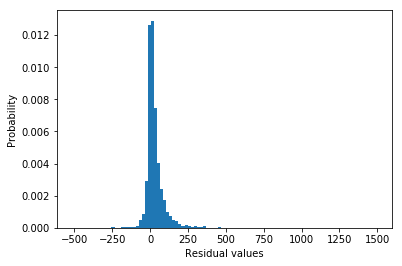

In [14]:
draw_hist(filter_data['sumPCIINext3M'])

The label forms a normal distribution, with a mean a bit above 0. We have a very unbalanced dataset.

In [13]:
def draw_residual_plot(feature, residual):
    plt.plot(feature, residual, 'ro')
    plt.axis([-200, 300, -200, 200])
    plt.xlabel('feature')
    plt.ylabel('residual')
    plt.show()

def draw_residual_hist(residual):
    plt.hist(residual, normed=1, bins=100) 
    plt.axis([-200, 300, 0, 0.03]) 
    #axis([xmin,xmax,ymin,ymax])
    plt.xlabel('Residuals')
    plt.ylabel('Probability')
    plt.show()
    
def draw_hist(residual):
    plt.hist(residual, normed=1, bins=100) 
    #plt.axis([-200, 300, 0, 0.03]) 
    #axis([xmin,xmax,ymin,ymax])
    plt.xlabel('Residual values')
    plt.ylabel('Probability')
    plt.show()

def calculate_std_error(residual):
    return sum(abs(residual))/len(residual)

def rmse(y, preds):
    return sqrt(mean_squared_error(y, preds))

def performance_evaluation(x_feature, y_true, y_pred):
    residual = y_true - y_pred
    print("Model Performance Evaluation")
    print("RMSE:{}. (the lower the better)".format(rmse(y_true, y_pred)))
    print("R-square:{}. (between [0,1] and higher the better)\n".format(r2_score(y_true, y_pred)))

    print("Residuals")
    print("Residual mean value: {}. (should be close to 0)".format(residual.mean()))
    draw_residual_plot(x_feature, residual)
    draw_residual_hist(residual)

In [15]:
data_train, data_test = train_test_split(filter_data,test_size=0.2, random_state=42)

# 1. Baseline model -- Mean Value 

In [39]:
X_train = data_train['sumPCII12M']
y_train = data_train['sumPCIINext3M']

average_spend_pq = X_train.mean()/4

In [40]:
preds = [average_spend_pq] * X_train.shape[0]

Model Performance Evaluation
RMSE:73.08716637033916. (the lower the better)
R-square:-0.02815031778850985. (between [0,1] and higher the better)

Residuals
Residual mean value: 12.093568484490895. (should be close to 0)


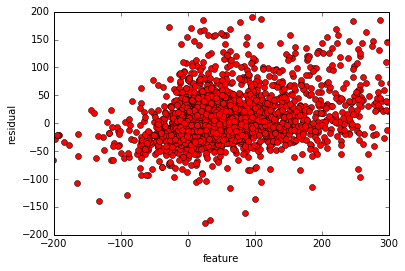

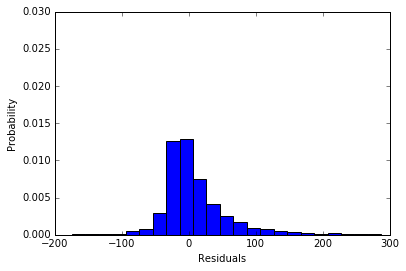

In [70]:
performance_evaluation(X_train, y_train, preds)

Check the performance on testing data.

In [53]:
X_test = data_test['sumPCII12M']
y_test = data_test['sumPCIINext3M']

preds_test = [average_spend_pq] * X_test.shape[0]

Model Performance Evaluation
RMSE:73.00093287036066. (the lower the better)
R-square:-0.029297618915961943. (between [0,1] and higher the better)

Residuals
Residual mean value: 12.31612501991574. (should be close to 0)


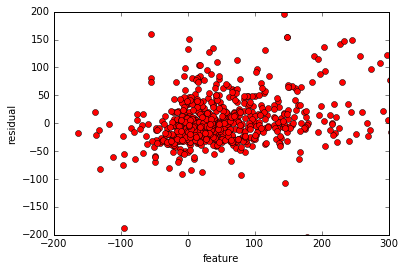

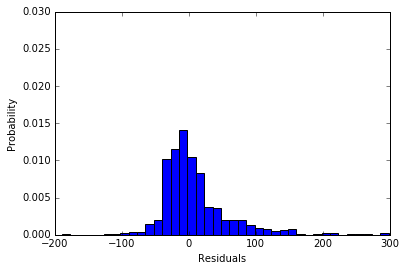

In [71]:
performance_evaluation(X_test, y_test, preds_test)

# OLS with one feature -- sumPCII12M

In [72]:
X_train = data_train['sumPCII12M']
y_train = data_train['sumPCIINext3M']

In [73]:
import statsmodels.api as sm

## let's add an intercept (beta_0) to our model
X = sm.add_constant(X_train)

# Note the difference in argument order
model = sm.OLS(y_train, X).fit()
preds = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sumPCIINext3M   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     1625.
Date:                Wed, 10 Oct 2018   Prob (F-statistic):          1.07e-283
Time:                        15:57:58   Log-Likelihood:                -16248.
No. Observations:                2966   AIC:                         3.250e+04
Df Residuals:                    2964   BIC:                         3.251e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2918      1.153     12.399      0.000      12.032      16.552
sumPCII12M     0.2226      0.006     40.313      0.000       0.212       0.233
==============================================================================
Omnibus:                     2344.263   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           150609.271
Skew:                           3.234   Prob(JB):                         0.00
Kurtosis:                      37.305   Cond. No.                         226.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model Performance Evaluation
RMSE:63.002924662268875. (the lower the better)
R-square:0.23333512058444417. (between [0,1] and higher the better)

Residuals
Residual mean value: 0.17993007673549719. (should be close to 0)


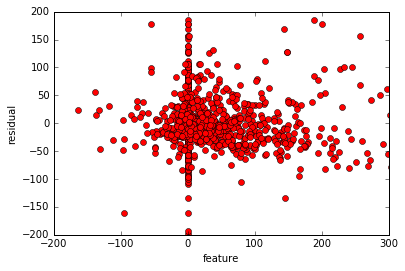

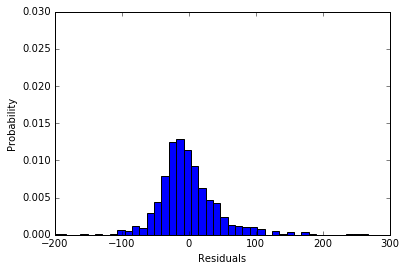

In [76]:
X_test = sm.add_constant(X_test)

preds_test = model.predict(X_test) # make the predictions by the model

performance_evaluation(X_test, y_test, preds_test)

34.588878840866506

# OLS with two features - sumPCII12M, numberOrdersWithCoupon12M

In [58]:
X_train = np.asarray(data_train[['sumPCII12M', 'totalSpendBeforeDiscount6M']])
y_train = data_train['sumPCIINext3M']

In [59]:
import statsmodels.api as sm

## let's add an intercept (beta_0) to our model
X_train = sm.add_constant(X_train)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
preds = model.predict(X_train) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sumPCIINext3M   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     935.2
Date:                Tue, 09 Oct 2018   Prob (F-statistic):               0.00
Time:                        21:01:05   Log-Likelihood:                -20364.
No. Observations:                3708   AIC:                         4.073e+04
Df Residuals:                    3705   BIC:                         4.075e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3197      1.133     10.872      0.000      10.098      14.541
x1             0.2125      0.005     40.864      0.000       0.202       0.223
x2             0.0046      0.001      5.453      0.000       0.003       0.006
==============================================================================
Omnibus:                     2983.601   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           214260.022
Skew:                           3.307   Prob(JB):                         0.00
Kurtosis:                      39.648   Cond. No.                     1.55e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

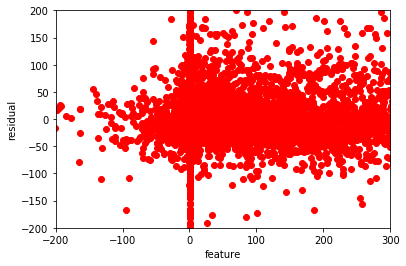

In [60]:
residual = y_train - preds
draw_residual_plot(X_train, residual)

In [61]:
rmse(y_train, preds)

58.73753566253807

# OLS with all features

In [51]:
X_train =data_train.drop(['registrationCountry', 'gender', 'customerHash', 'sumPCIINext3M'], axis=1)
y_train = data_train['sumPCIINext3M']

In [57]:
import statsmodels.api as sm

## let's add an intercept (beta_0) to our model
X_train = sm.add_constant(X_train)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
preds = model.predict(X_train) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sumPCIINext3M   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     28.29
Date:                Tue, 09 Oct 2018   Prob (F-statistic):               0.00
Time:                        21:00:36   Log-Likelihood:                -20108.
No. Observations:                3708   AIC:                         4.040e+04
Df Residuals:                    3614   BIC:                         4.099e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          10.4175      3.376      3.086      0.002       3.799      17.036
sumPCII1M                      -0.0549      0.110     -0.498      0.618      -0.271       0.161
avgPCII1M                      -0.5203      0.538     -0.967      0.334      -1.575       0.535
totalSpendBeforeDiscount1M      0.0172      0.021      0.830      0.407      -0.023       0.058
totalSpendBeforeCoupon1M       -0.0001      0.037     -0.003      0.997      -0.073       0.073
numberOrders1M                  2.1962      2.195      1.000      0.317      -2.108       6.500
numberItems1M                   1.1560      1.356      0.853      0.394      -1.502       3.814
numberReturnedItems1M          -2.5083      1.935     -1.296      0.195      -6.302       1.286
avgNumberItems1M                2.4986      4.706      0.531      0.596      -6.729      11.726
gmvReturnedItems1M             -0.0104      0.049     -0.214      0.830      -0.106       0.085
gmvDiscount1M                   0.0173      0.043      0.408      0.683      -0.066       0.101
gmvWithCoupon1M                -0.0023      0.026     -0.088      0.930      -0.054       0.049
numberOrdersWithCoupon1M        0.9344      6.730      0.139      0.890     -12.260      14.129
sumPCII3M                       0.2707      0.188      1.442      0.149      -0.097       0.639
avgPCII3M                       0.7462      1.056      0.707      0.480      -1.324       2.816
totalSpendBeforeDiscount3M      0.0119      0.022      0.542      0.588      -0.031       0.055
totalSpendBeforeCoupon3M        0.0029      0.052      0.055      0.956      -0.100       0.105
numberOrders3M                  2.8507      3.411      0.836      0.403      -3.836       9.538
numberItems3M                  -1.9693      1.742     -1.130      0.258      -5.385       1.447
numberReturnedItems3M           4.6433      2.492      1.863      0.063      -0.243       9.530
avgNumberItems3M               -8.7224      5.547     -1.573      0.116     -19.597       2.152
gmvReturnedItems3M             -0.0230      0.072     -0.321      0.748      -0.163       0.117
gmvDiscount3M                   0.0090      0.051      0.176      0.860      -0.091       0.109
gmvWithCoupon3M                 0.0202      0.045      0.445      0.656      -0.069       0.109
numberOrdersWithCoupon3M      -10.0670     10.926     -0.921      0.357     -31.488      11.354
sumPCII6M                      -0.0402      0.229     -0.175      0.861      -0.490       0.409
avgPCII6M                       0.6030      0.701      0.860      0.390      -0.772       1.978
totalSpendBeforeDiscount6M      0.1852      0.041      4.504      0.000       0.105       0.266
totalSpendBeforeCoupon6M       -0.0056      0.075     -0.075      0.941      -0.152       0.141
numberOrder

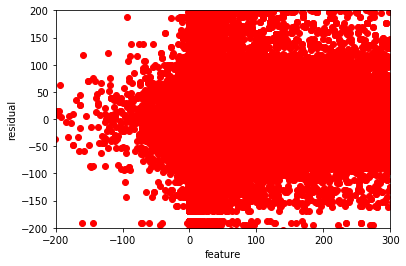

In [54]:
residual = y_train - preds
draw_residual_plot(X_train, residual)

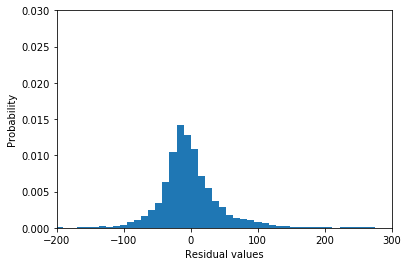

In [55]:
draw_residual_hist(residual)

In [56]:
rmse(y_train, preds)

54.81538845517702

# Random Forest -- random try

In [62]:
X_train =data_train.drop(['registrationCountry', 'gender', 'customerHash', 'sumPCIINext3M'], axis=1)
y_train = data_train['sumPCIINext3M']

In [71]:

regr_rf = RandomForestRegressor(n_estimators=200, max_depth=20,
                                random_state=2)
regr_rf.fit(X_train, y_train)

# Predict on new data
preds = regr_rf.predict(X_train)

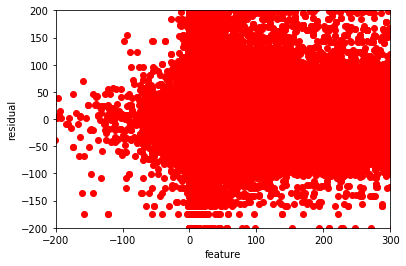

In [68]:
residual = y_train - preds
draw_residual_plot(X_train, residual)

In [72]:
rmse(y_train, preds)

27.559636335006918

In [73]:
calculate_std_error(residual)

31.814195957451545

# Random forest -- parameter tunning

In [22]:
X_train =data_train.drop(['registrationCountry', 'gender', 'customerHash', 'sumPCIINext3M'], axis=1)
y_train = data_train['sumPCIINext3M']

In [17]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 98.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [24]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [25]:
best_rf = rf_random.best_estimator_

preds = best_rf.predict(X_train)

Model Performance Evaluation
RMSE:39.0203017069988. (the lower the better)
R-square:0.7069406301334897. (between [0,1] and higher the better)

Residuals
Residual mean value: 0.07300793804170881. (should be close to 0)


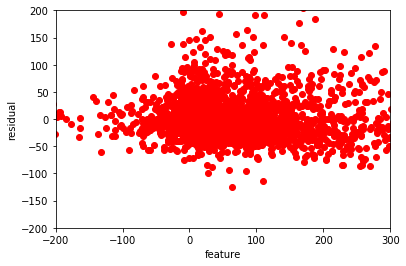

/Users/zhenxing/Envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


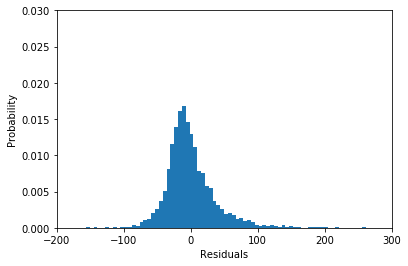

In [27]:
performance_evaluation(X_train['sumPCII12M'], y_train, preds)

In [28]:
X_test =data_test.drop(['registrationCountry', 'gender', 'customerHash', 'sumPCIINext3M'], axis=1)
y_test = data_test['sumPCIINext3M']

Model Performance Evaluation
RMSE:63.73222851316662. (the lower the better)
R-square:0.21548300257532327. (between [0,1] and higher the better)

Residuals
Residual mean value: 0.48577386245744963. (should be close to 0)


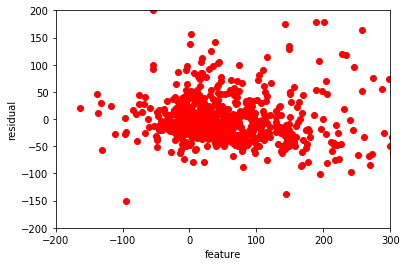

/Users/zhenxing/Envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


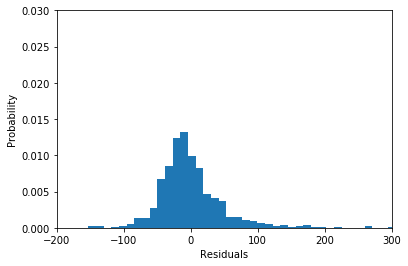

In [30]:
preds_test = best_rf.predict(X_test)
performance_evaluation(X_test['sumPCII12M'], y_test, preds_test)